In [1]:
import myplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tri

myplotlib.load("hershey")

In [6]:
# Change this to the path where your data is stored
PATH = "../temp/out-inj1e2-esc1e2"

In [7]:
# First combine the hdf5 files into a single file for faster loading
tri.CombineH5Files(PATH)

In [8]:
# Load the spectra at different times
spectra = tri.get(f"{PATH}/data.h5")
spectra

<xarray.Dataset>
Dimensions:  (t: 101, e: 300)
Coordinates:
  * t        (t) int64 0 50 100 150 200 250 ... 4750 4800 4850 4900 4950 5000
  * e        (e) float32 0.0001023 0.0001072 0.0001122 ... 89.13 93.33 97.72
Data variables:
    n1       (t, e) float32 dask.array<chunksize=(1, 300), meta=np.ndarray>
    n2       (t, e) float32 dask.array<chunksize=(1, 300), meta=np.ndarray>
    n3       (t, e) float32 dask.array<chunksize=(1, 300), meta=np.ndarray>
Attributes: (12/132)
    NumSteps:                  101
    algorithm:c:               0.45
    algorithm:corr:            1.025
    algorithm:currdeposit:     1
    algorithm:fieldsolver:     1
    algorithm:nfilter:         10
    ...                        ...
    slice_output:sliceY_1:     -1.0
    slice_output:sliceZ_1:     -1.0
    slice_output:start:        0
    time:last:                 5000
    time:wall_t_max:           0.0
    timestep:                  0

In [ ]:
Te = spectra.attrs["problem:Te"][()]
tau0 = spectra.attrs["qed:tau0"][()]
CC = spectra.attrs["algorithm:c"][()]
t_c = 1 / (CC * tau0)
last_t = spectra.t[-1].values[()] / t_c
factor = np.log(10) * (2 * np.pi)
energies = spectra.e

fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot(111)
for i, t in enumerate(spectra.t):
    e_dn_de = energies * spectra.n3.sel(t=t)
    norm = np.trapz(spectra.n3.sel(t=t) / energies, energies) * factor
    e_dn_de /= norm
    ax.plot(
        energies * 511,
        e_dn_de * 511,
        c="C5",
        alpha=(i / len(spectra.t)),
        label="photons" if i == len(spectra.t) - 1 else None,
    )
n_th = energies**2 / (np.exp(energies / Te) - 1)
norm = np.trapz(n_th, energies) * factor
n_th /= norm
ax.plot(energies * 511, energies**2 * n_th * 511, c="C0", ls="--")

ax.set(
    xscale="log",
    yscale="log",
    xlim=(0.1, 1e4),
    ylim=(1e-5, 100),
    xlabel=r"$\varepsilon$, keV",
    ylabel=r"$\varepsilon^2 dn_\varepsilon/d\varepsilon$ [normalized]",
    title=rf"$t={{{last_t:.1f}}}~t_c$",
)
ax.legend()

In [2]:
# convert all
paths = ["out-steady", "out-inj1e2-esc1e3", "out-inj1e2-esc1e2", "out-inj10-esc20", "out-inj10-esc10"]

for path in paths:
    tri.CombineH5Files(f"../temp/{path}/")

In [3]:
spectra = [tri.get(f"../temp/{path}/data.h5") for path in paths]

In [4]:
for path, sp in zip(paths, spectra):
    factor = np.log(10) / sp.attrs["output:interval"][()]
    if "steady" in path:
        continue
    print(
        "t_inj =",
        sp.attrs["problem:t_inject"],
        "\tt_esc =",
        sp.attrs["problem:t_escape"],
        "\tnphot =",
        sp.n3.isel(t=-1).sum().values[()] / 1e6,
        "\tnphot_int =",
        np.trapz(sp.n3.isel(t=-1) / sp.e, sp.e) / 1e6 / factor,
        "\teph0 =",
        np.trapz(sp.n3.isel(t=0), sp.e) / np.trapz(sp.n3.isel(t=0) / sp.e, sp.e),
    )

t_inj = 100.0 	t_esc = 1000.0 	nphot = 2.003115 	nphot_int = 2.0036593252460224 	eph0 = 0.0027609935
t_inj = 100.0 	t_esc = 100.0 	nphot = 2.00025 	nphot_int = 1.9998512751541153 	eph0 = 0.0027016976
t_inj = 10.0 	t_esc = 20.0 	nphot = 2.000486 	nphot_int = 1.9993335147014712 	eph0 = 0.0026986704
t_inj = 10.0 	t_esc = 10.0 	nphot = 2.00148 	nphot_int = 2.0002109252719413 	eph0 = 0.0027000871


/home/hayk/Codes/tristan-v2-mini/.venv/lib/python3.10/site-packages/xarray/core/computation.py:760: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


[None, None]

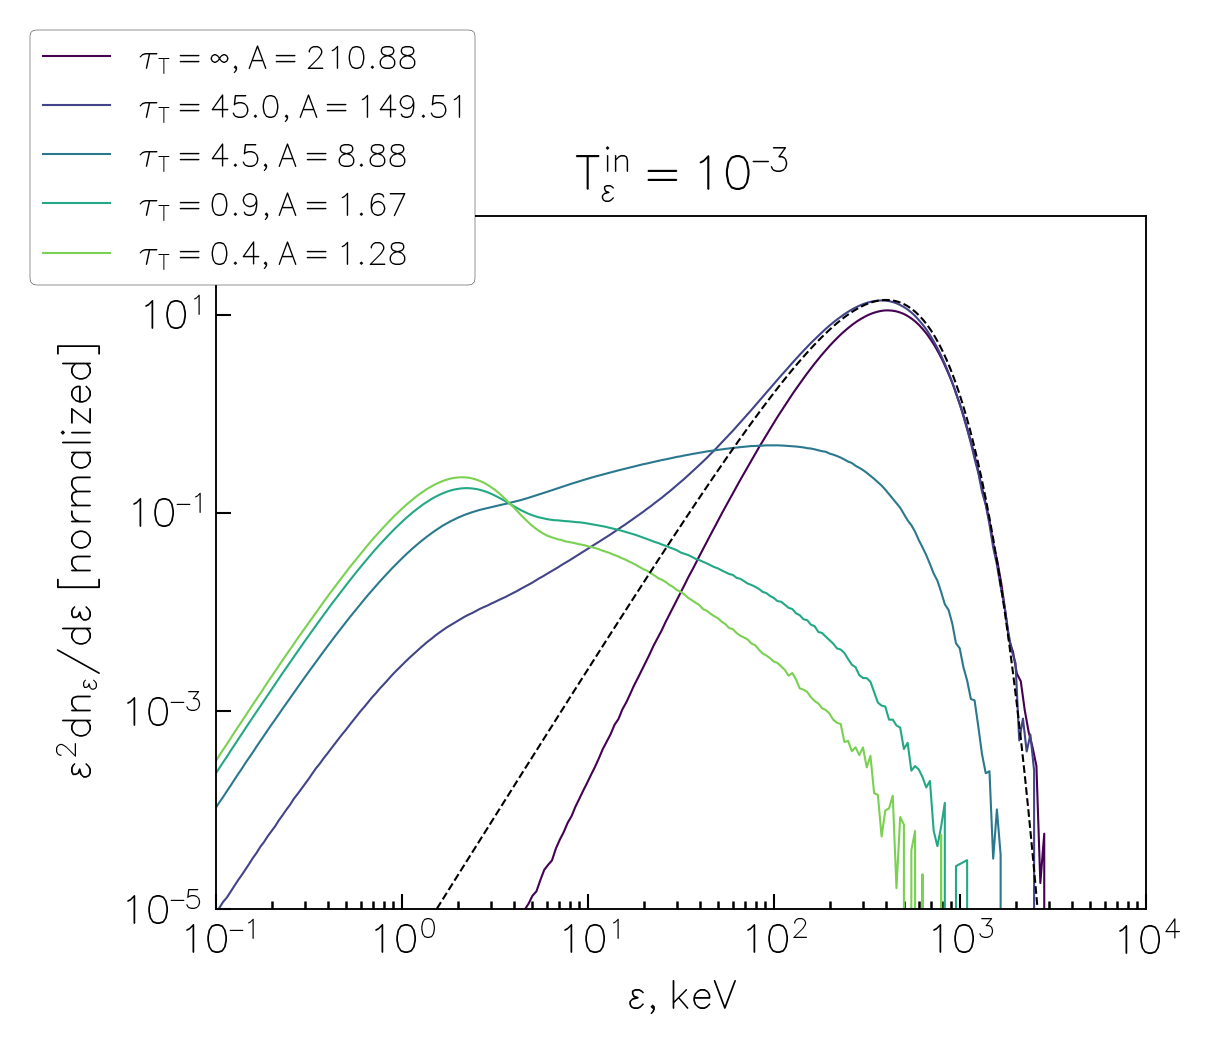

In [5]:
Te = spectra[0].attrs["problem:Te"][()]
Tin = spectra[0].attrs["problem:Tph0"][()]
tau0 = spectra[0].attrs["qed:tau0"][()]
CC = spectra[0].attrs["algorithm:c"][()]

t_c = 1 / (CC * tau0)

fig = plt.figure(figsize=(4, 3), dpi=300)
ax = fig.add_subplot(111)
for i, sp in enumerate(spectra):
    tmin = 1500
    factor = np.log(10) / sp.attrs["output:interval"][()]

    if "steady" in paths[i]:
        tauT = "\infty"
    else:
        tauT = (
            sp.attrs["qed:tau0"][()]
            * sp.attrs["algorithm:c"][()]
            * sp.attrs["problem:t_escape"][()]
        )
        tauT = f"{tauT:.1f}"

    def select(f):
        return f.n3.sel(t=slice(tmin, None)).mean("t")

    eph0 = np.trapz(sp.n3.isel(t=0), sp.e) / np.trapz(sp.n3.isel(t=0) / sp.e, sp.e)
    epht = np.trapz(select(sp), sp.e) / np.trapz(select(sp) / sp.e, sp.e)
    A = f"{epht / eph0:.2f}"

    coeff = 2e6 / select(sp).sum().values[()]
    energies = sp.e
    e_dn_de = energies * select(sp)
    norm = np.trapz(select(sp) / energies, energies) / factor
    e_dn_de /= norm
    ax.plot(
        energies * 511,
        e_dn_de * 511 * coeff * (i + 1),
        label=rf"$\tau_T={{{tauT}}}$, $A={{{A}}}$",
        c=mpl.colormaps["viridis"](i / len(spectra)),
    )

energies = spectra[0].e
n_th = energies**2 / (np.exp(energies / Te) - 1)
norm = np.trapz(n_th, energies) * (np.log(10) * (2 * np.pi))
n_th /= norm
ax.plot(energies * 511, energies**2 * n_th * 511, c="C0", ls="--")
ax.set(
    xscale="log",
    yscale="log",
    xlim=(0.1, 1e4),
    ylim=(1e-5, 100),
    xlabel=r"$\varepsilon$, keV",
    ylabel=r"$\varepsilon^2 dn_\varepsilon/d\varepsilon$ [normalized]",
)
ax.set(title=rf"$T_\varepsilon^{{\rm in}}=10^{{{int(np.log10(Tin))}}}$")
leg = ax.legend(loc=(-0.2, 0.9), fontsize=8, frameon=True, framealpha=1)
leg.get_frame().set(linewidth=0.1, edgecolor="k")